In [1]:
import numpy as np
import pandas as pd
import datetime
import calendar
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pymysql
from sqlalchemy import create_engine
import getpass

In [2]:
password = getpass.getpass()

 ········


In [3]:
# READING THE DATA
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)
data = pd.read_sql('''SELECT i.inventory_id, f.film_id, f.title, f.rental_duration, f.rental_rate, f.length, f.replacement_cost,  f.rating, f.special_features, i.store_id,  r.staff_id, r.rental_date,
CASE
WHEN r.rental_date BETWEEN '2005-01-01' AND '2005-08-1' THEN r.rental_date
ELSE NULL
END AS last_time_rented,
CASE
WHEN MAX(r.rental_date) BETWEEN '2005-08-01' AND '2005-08-31' THEN 1
ELSE 0
END AS rented_last_month, COUNT(r.inventory_id) AS times_rented,
CASE
WHEN MIN(r.rental_date) BETWEEN '2005-01-01' AND '2005-08-1' THEN 1
ELSE 0
END AS rented_before_august
FROM sakila.film f
LEFT JOIN sakila.inventory i USING (film_id)
LEFT JOIN sakila.rental r USING (inventory_id)
WHERE (r.rental_date BETWEEN '2005-01-01' AND '2005-08-31') OR r.rental_date IS NULL
GROUP BY i.inventory_id
ORDER BY i.inventory_id ASC;''', engine)
data

# LEFTs JOINs IN film BECAUSE MAYBE THERE ARE FILMS WHICH HAVE NEVER BEEN RENTED, AND THE SAME FOR THE HAVING "OR MAX(r.rental_date) IS NULL"
# I WANTED TO OBTAIN A COLUMN WHICH HAD THE TIMES THIS FILM HAD BEEN RENTED BEFORE AUGUST, BUT I COULDN'T

,inventory_id,film_id,title,rental_duration,rental_rate,length,replacement_cost,rating,special_features,store_id,staff_id,rental_date,last_time_rented,rented_last_month,times_rented,rented_before_august
0,NaN,14,ALICE FANTASIA,6,0.99,94,23.99,NC-17,"Trailers,Deleted Scenes,Behind the Scenes",NaN,NaN,NaT,NaT,0,0,0
1,1.0,1,ACADEMY DINOSAUR,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",1.0,2.0,2005-07-08 19:03:15,2005-07-08 19:03:15,1,3,1
2,2.0,1,ACADEMY DINOSAUR,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",1.0,1.0,2005-05-30 20:21:07,2005-05-30 20:21:07,1,5,1
3,3.0,1,ACADEMY DINOSAUR,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",1.0,1.0,2005-07-31 21:36:07,2005-07-31 21:36:07,1,2,1
4,4.0,1,ACADEMY DINOSAUR,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",1.0,1.0,2005-08-02 00:47:19,NaT,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4577,4577.0,1000,ZORRO ARK,3,4.99,50,18.99,NC-17,"Trailers,Commentaries,Behind the Scenes",1.0,1.0,2005-05-31 11:10:17,2005-05-31 11:10:17,1,5,1
4578,4578.0,1000,ZORRO ARK,3,4.99,50,18.99,NC-17,"Trailers,Commentaries,Behind the Scenes",2.0,1.0,2005-07-12 11:28:22,2005-07-12 11:28:22,1,3,1
4579,4579.0,1000,ZORRO ARK,3,4.99,50,18.99,NC-17,"Trailers,Commentaries,Behind the Scenes",2.0,1.0,2005-05-28 11:33:46,2005-05-28 11:33:46,1,5,1
4580,4580.0,1000,ZORRO ARK,3,4.99,50,18.99,NC-17,"Trailers,Commentaries,Behind the Scenes",2.0,1.0,2005-08-01 10:11:25,NaT,1,2,0


In [4]:
# NAN VALUES
data.isna().sum()

inventory_id              1
film_id                   0
title                     0
rental_duration           0
rental_rate               0
length                    0
replacement_cost          0
rating                    0
special_features          0
store_id                  1
staff_id                  2
rental_date               2
last_time_rented        328
rented_last_month         0
times_rented              0
rented_before_august      0
dtype: int64

In [5]:
# INVENTORY ID NAN SOLUTION
data['inventory_id'] = data['inventory_id'].replace(np.nan,0)

In [6]:
data.isna().sum()

inventory_id              0
film_id                   0
title                     0
rental_duration           0
rental_rate               0
length                    0
replacement_cost          0
rating                    0
special_features          0
store_id                  1
staff_id                  2
rental_date               2
last_time_rented        328
rented_last_month         0
times_rented              0
rented_before_august      0
dtype: int64

In [7]:
# TO SOLVE THE NAN VALUE IN STORE_ID I CAN PUT THAT FILM IN ONE OF THESE TWO STORES, FOR EXAMPLE IN THE STORE 1. SAME FOR STAFF ID
data['store_id'] = data['store_id'].replace(np.nan,1)
data['staff_id'] = data['staff_id'].replace(np.nan,1)

In [8]:
data.isna().sum()

inventory_id              0
film_id                   0
title                     0
rental_duration           0
rental_rate               0
length                    0
replacement_cost          0
rating                    0
special_features          0
store_id                  0
staff_id                  0
rental_date               2
last_time_rented        328
rented_last_month         0
times_rented              0
rented_before_august      0
dtype: int64

In [9]:
# THE COLUMN RENTAL DATE ISN'T IMPORTANT, SO I CAN DELETE IT.  
data = data.drop(['rental_date'], axis = 1)

In [10]:
data.isna().sum()

inventory_id              0
film_id                   0
title                     0
rental_duration           0
rental_rate               0
length                    0
replacement_cost          0
rating                    0
special_features          0
store_id                  0
staff_id                  0
last_time_rented        328
rented_last_month         0
times_rented              0
rented_before_august      0
dtype: int64

In [11]:
# NOW, FOR THE LAST TIME RENTED I'M GOING TO USE IT TO CREATE A NEW COLUMN AND THEN DELETE IT
# THIS COLUMN IS GOING TO BE "LAST MONTH RENTED" WITH 0 IF NOT AND 1 IF YES

In [12]:
def clean_date(row): 
    row['last_time_rented'] = row['last_time_rented'].replace(np.nan,0)   #GIVING A VALUE THAN LATER I CAN IDENTIFY
    row['last_month_rented'] = 'never'    #CREATING THE NEW COLUMN
    for i in range(len(row['last_time_rented'])):
        if row['last_time_rented'][i] == 0:
            row['last_month_rented'][i] = 'never'
        else:
            date = row['last_time_rented'][i].month
            row['last_month_rented'][i] = calendar.month_name[date]
    row = row.drop(['last_time_rented'], axis = 1)
    return row

In [13]:
data = clean_date(data)
data

<ipython-input-12-0c428594d35d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['last_month_rented'][i] = 'never'
<ipython-input-12-0c428594d35d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['last_month_rented'][i] = calendar.month_name[date]


,inventory_id,film_id,title,rental_duration,rental_rate,length,replacement_cost,rating,special_features,store_id,staff_id,rented_last_month,times_rented,rented_before_august,last_month_rented
0,0.0,14,ALICE FANTASIA,6,0.99,94,23.99,NC-17,"Trailers,Deleted Scenes,Behind the Scenes",1.0,1.0,0,0,0,never
1,1.0,1,ACADEMY DINOSAUR,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",1.0,2.0,1,3,1,July
2,2.0,1,ACADEMY DINOSAUR,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",1.0,1.0,1,5,1,May
3,3.0,1,ACADEMY DINOSAUR,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",1.0,1.0,1,2,1,July
4,4.0,1,ACADEMY DINOSAUR,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",1.0,1.0,1,2,0,never
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4577,4577.0,1000,ZORRO ARK,3,4.99,50,18.99,NC-17,"Trailers,Commentaries,Behind the Scenes",1.0,1.0,1,5,1,May
4578,4578.0,1000,ZORRO ARK,3,4.99,50,18.99,NC-17,"Trailers,Commentaries,Behind the Scenes",2.0,1.0,1,3,1,July
4579,4579.0,1000,ZORRO ARK,3,4.99,50,18.99,NC-17,"Trailers,Commentaries,Behind the Scenes",2.0,1.0,1,5,1,May
4580,4580.0,1000,ZORRO ARK,3,4.99,50,18.99,NC-17,"Trailers,Commentaries,Behind the Scenes",2.0,1.0,1,2,0,never


In [14]:
data.isna().sum()

inventory_id            0
film_id                 0
title                   0
rental_duration         0
rental_rate             0
length                  0
replacement_cost        0
rating                  0
special_features        0
store_id                0
staff_id                0
rented_last_month       0
times_rented            0
rented_before_august    0
last_month_rented       0
dtype: int64

In [15]:
# TYPES OF DATA
data.dtypes

inventory_id            float64
film_id                   int64
title                    object
rental_duration           int64
rental_rate             float64
length                    int64
replacement_cost        float64
rating                   object
special_features         object
store_id                float64
staff_id                float64
rented_last_month         int64
times_rented              int64
rented_before_august      int64
last_month_rented        object
dtype: object

In [16]:
data['rating'].unique()

array(['NC-17', 'PG', 'G', 'PG-13', 'R'], dtype=object)

In [17]:
data['replacement_cost'].unique()

array([23.99, 20.99, 12.99, 18.99, 26.99, 22.99, 17.99, 28.99, 15.99,
       21.99, 24.99, 16.99, 10.99, 14.99, 27.99,  9.99, 19.99, 11.99,
       29.99, 13.99, 25.99])

In [18]:
data['replacement_cost'].value_counts()

22.99    303
27.99    268
21.99    263
20.99    254
29.99    246
12.99    245
14.99    235
13.99    230
11.99    216
26.99    213
25.99    211
28.99    208
17.99    206
10.99    204
23.99    201
9.99     195
18.99    194
19.99    184
24.99    174
16.99    173
15.99    159
Name: replacement_cost, dtype: int64

In [19]:
categorical = data.select_dtypes(include = np.object)
categorical = categorical.drop(['title'], axis =1)
categorical

<ipython-input-19-61f8b20028bc>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical = data.select_dtypes(include = np.object)


,rating,special_features,last_month_rented
0,NC-17,"Trailers,Deleted Scenes,Behind the Scenes",never
1,PG,"Deleted Scenes,Behind the Scenes",July
2,PG,"Deleted Scenes,Behind the Scenes",May
3,PG,"Deleted Scenes,Behind the Scenes",July
4,PG,"Deleted Scenes,Behind the Scenes",never
...,...,...,...
4577,NC-17,"Trailers,Commentaries,Behind the Scenes",May
4578,NC-17,"Trailers,Commentaries,Behind the Scenes",July
4579,NC-17,"Trailers,Commentaries,Behind the Scenes",May
4580,NC-17,"Trailers,Commentaries,Behind the Scenes",never


In [20]:
data['rented_last_month'].value_counts()

1    4426
0     156
Name: rented_last_month, dtype: int64

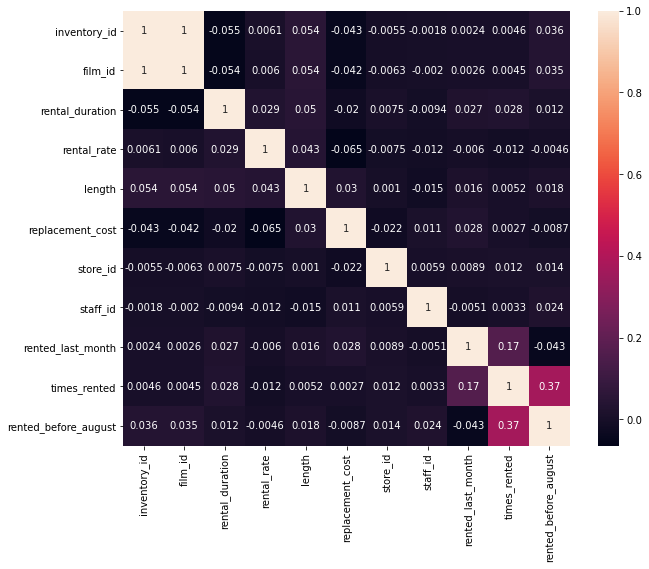

In [21]:
import seaborn as sns
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [22]:
data = data.drop(['film_id'], axis =1)

In [23]:
# TRAIN TEST SPLIT BEFORE I APPLY TRANSFORMATIONS
y = data['rented_last_month']
X = data.drop(['rented_last_month','title'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [24]:
#TRANSFORMATIONS
import numpy as np
from sklearn.preprocessing import MinMaxScaler

X_train_num = X_train.select_dtypes(include = np.number)

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized)

In [25]:
X_train_norm.columns = X_train_num.columns
X_train_norm.head()

,inventory_id,rental_duration,rental_rate,length,replacement_cost,store_id,staff_id,times_rented,rented_before_august
0,0.004802,0.50,0.5,0.510791,0.85,1.0,0.0,0.6,1.0
1,0.402096,0.75,0.0,0.877698,0.05,0.0,0.0,1.0,1.0
2,0.766427,0.00,1.0,0.402878,0.10,1.0,1.0,0.8,1.0
3,0.655534,1.00,0.5,0.539568,0.50,1.0,1.0,0.8,1.0
4,0.931238,0.50,0.5,0.273381,0.35,0.0,0.0,0.6,1.0


In [26]:
X_train_categorical = X_train.select_dtypes(include = np.object)
X_train_cat = pd.get_dummies(X_train_categorical, 
                             columns=['rating', 'special_features', 'last_month_rented'],
                             drop_first=True)
X_train_cat.head()

<ipython-input-26-70291e2e826e>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train_categorical = X_train.select_dtypes(include = np.object)


,rating_NC-17,rating_PG,rating_PG-13,rating_R,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes","special_features_Commentaries,Deleted Scenes","special_features_Commentaries,Deleted Scenes,Behind the Scenes",special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",...,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes",last_month_rented_June,last_month_rented_May,last_month_rented_never
22,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1842,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3511,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3003,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4266,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)

In [28]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='saga',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [29]:
X_test_num = X_test.select_dtypes(include = np.number)

In [30]:
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)

In [31]:
# for categoricals
X_test_categorical = X_test.select_dtypes(include = np.object)
X_test_cat = pd.get_dummies(X_test_categorical, 
                            columns=['rating', 'special_features', 'last_month_rented'],
                            drop_first=True)
# verify that dummies columns are in the same order and that the same column was dropped
display(list(zip(list(X_train_cat.columns),list(X_test_cat.columns))))
# not needed if you treat each original column seperately with one_hot_encoder

X_test_cat.head()

<ipython-input-31-fe36968c7723>:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test_categorical = X_test.select_dtypes(include = np.object)


[('rating_NC-17', 'rating_NC-17'),
 ('rating_PG', 'rating_PG'),
 ('rating_PG-13', 'rating_PG-13'),
 ('rating_R', 'rating_R'),
 ('special_features_Commentaries', 'special_features_Commentaries'),
 ('special_features_Commentaries,Behind the Scenes',
  'special_features_Commentaries,Behind the Scenes'),
 ('special_features_Commentaries,Deleted Scenes',
  'special_features_Commentaries,Deleted Scenes'),
 ('special_features_Commentaries,Deleted Scenes,Behind the Scenes',
  'special_features_Commentaries,Deleted Scenes,Behind the Scenes'),
 ('special_features_Deleted Scenes', 'special_features_Deleted Scenes'),
 ('special_features_Deleted Scenes,Behind the Scenes',
  'special_features_Deleted Scenes,Behind the Scenes'),
 ('special_features_Trailers', 'special_features_Trailers'),
 ('special_features_Trailers,Behind the Scenes',
  'special_features_Trailers,Behind the Scenes'),
 ('special_features_Trailers,Commentaries',
  'special_features_Trailers,Commentaries'),
 ('special_features_Trailer

,rating_NC-17,rating_PG,rating_PG-13,rating_R,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes","special_features_Commentaries,Deleted Scenes","special_features_Commentaries,Deleted Scenes,Behind the Scenes",special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",...,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes",last_month_rented_June,last_month_rented_May,last_month_rented_never
3137,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4290,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3863,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
266,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1935,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [32]:
X_test_transformed = np.concatenate([X_test_norm, X_test_cat], axis=1)

In [33]:
# Now we can make predictions on the test set:
predictions = classification.predict(X_test_transformed)
classification.score(X_test_transformed, y_test)

0.9672846237731734

In [34]:
print(y_test.value_counts())

1    880
0     37
Name: rented_last_month, dtype: int64


In [35]:
pd.Series(predictions).value_counts()

1    910
0      7
dtype: int64

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[  7,  30],
       [  0, 880]], dtype=int64)